In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from collections import defaultdict

In [2]:
with open('../data/moby/jsons/response_to_annote_category_to_scores.json') as f:
    response_to_annote_category_to_scores = json.load(f)
with open('../data/moby/jsons/child_response_to_session.json') as f:
    child_response_to_session = json.load(f)
with open('../data/moby/jsons/session_to_form.json') as f:
    session_to_form = json.load(f)
with open('../data/moby/jsons/child_response_to_wcpm.json') as f:
    child_response_to_wcpm = json.load(f)
with open('../data/moby/jsons/child_response_to_item.json') as f:
    child_response_to_item = json.load(f)
with open('../data/moby/pkls/session_to_pause_length_data-updated.pkl', 'rb') as f:
    session_to_data = pkl.load(f)
with open('../data/moby/jsons/session_to_wcpm.json') as f:
    session_to_wcpm = json.load(f)
with open('../data/moby/jsons/item_to_form.json') as f:
    item_to_form = json.load(f)

good_child_readings_data = pd.read_csv('good_child_punct_metrics_updated.csv')
gold_readings_data = pd.read_csv('gold_punct_metrics_updated.csv')

In [3]:
average_cat_12_list = []
average_cat_14_list = []
response_list = []
session_list= []
form_list = []
grade_list = []
item_list = []

for response, annote_category_to_scores in response_to_annote_category_to_scores.items():

    if response not in child_response_to_session:
        print(response)
        continue
    session = child_response_to_session[response]
    form = session_to_form[str(session)]
          
    if '12' not in annote_category_to_scores or '14' not in annote_category_to_scores:
        continue
    
    response_list.append(response)
    session_list.append(session)
    form_list.append(form)
    grade_list.append(form.replace('Spring', '').replace('Winter', '').replace('Fall', ''))
    item_list.append(child_response_to_item[str(response)])
    
    average_cat_12_list.append(np.mean(annote_category_to_scores['12']))
    average_cat_14_list.append(np.mean(annote_category_to_scores['14']))

In [4]:
df = pd.DataFrame({
    'Session': session_list,
    'Response': response_list,
    'Item': item_list,
    'Form': form_list,
    'Grade': grade_list,
    'AvgAnnote12': average_cat_12_list,
    'AvgAnnote14': average_cat_14_list
})

In [5]:
sessions_to_keep = []
for idx1_for_plotting, grade in enumerate(['Grade1', 'Grade2', 'Grade3', 'Grade4']):
    for idx2_for_plotting, term in enumerate(['Fall', 'Winter', 'Spring']):
        df_this_form = df.loc[df.Form == grade + term]
        df_this_form_perfect12 = df_this_form.loc[df_this_form.AvgAnnote12 == 3]
        sessions = set(df_this_form_perfect12.Session)
        sessions = list(set(x for x in sessions if list(df_this_form_perfect12.Session).count(x) == 3))
        print(grade + term, len(sessions))
        sessions_sorted_by_wcpm = list(reversed(sorted(sessions, key=(lambda x: float(session_to_wcpm[str(x)])))))
        
#         Keep only middle 15 (or less)
        while len(sessions_sorted_by_wcpm) > 15:
            sessions_sorted_by_wcpm = sessions_sorted_by_wcpm[1:]
            if len(sessions_sorted_by_wcpm) == 15:
                break
            sessions_sorted_by_wcpm = sessions_sorted_by_wcpm[:-1]
            
        sessions_to_keep += sessions_sorted_by_wcpm

# with open('good_child_sessions_wrt_cat_12.json', 'w') as f:
#     json.dump(sessions_to_keep, f)

Grade1Fall 15
Grade1Winter 9
Grade1Spring 14
Grade2Fall 24
Grade2Winter 27
Grade2Spring 25
Grade3Fall 17
Grade3Winter 37
Grade3Spring 46
Grade4Fall 38
Grade4Winter 22
Grade4Spring 42


In [6]:
def avg_abs_diff(a, b):
    return np.mean(np.abs(np.array(a) - np.array(b)))

In [7]:
def filtered(orig, msk):
#     print(orig, msk)
    temp_orig = list(orig)
    return [temp_orig[x] for x in range(len(temp_orig)) if x in msk]

In [8]:
def compute_avg_dev_below_1q(data_pause_len,
                             data_mean_span_pause_len,
                             gold_pause_mean,
                             gold_pause_1q,
                             gold_pause_sstd,
                             is_correct_array=None):
    
    indices_to_keep = set(range(len(data_pause_len)))
    if is_correct_array:
        indices_to_keep = set(x for x in range(len(is_correct_array)) if is_correct_array[x] == 1)
        
    if len(indices_to_keep) < len(data_pause_len) / 2:
        return 10
    indices_to_keep = set(range(min(indices_to_keep), max(indices_to_keep) + 1))
    
    data_normalized_pauses = np.array(data_pause_len) - data_mean_span_pause_len
    data_normalized_pauses = filtered(data_normalized_pauses, indices_to_keep)
    diff_from_1q = data_normalized_pauses - np.array(filtered(gold_pause_1q, indices_to_keep))
    devs_from_1q = diff_from_1q / filtered(list(gold_pause_sstd), indices_to_keep)
    return np.mean(devs_from_1q)

In [9]:
def compute_proportion_below_1q(data_pause_len,
                                data_mean_span_pause_len,
                                gold_pause_mean,
                                gold_pause_1q,
                                gold_pause_sstd,
                                is_correct_array=None):
    
    indices_to_keep = set(range(len(data_pause_len)))
    if is_correct_array:
        indices_to_keep = set(x for x in range(len(is_correct_array)) if is_correct_array[x] == 1)
        
    if len(indices_to_keep) < len(data_pause_len) / 2:
        return 10
    indices_to_keep = set(range(min(indices_to_keep), max(indices_to_keep) + 1))
    
    data_normalized_pauses = np.array(data_pause_len) - data_mean_span_pause_len
    data_normalized_pauses = filtered(data_normalized_pauses, indices_to_keep)
    above_expected_1q = data_normalized_pauses < np.array(filtered(list(gold_pause_1q), indices_to_keep))
    return np.mean(above_expected_1q)

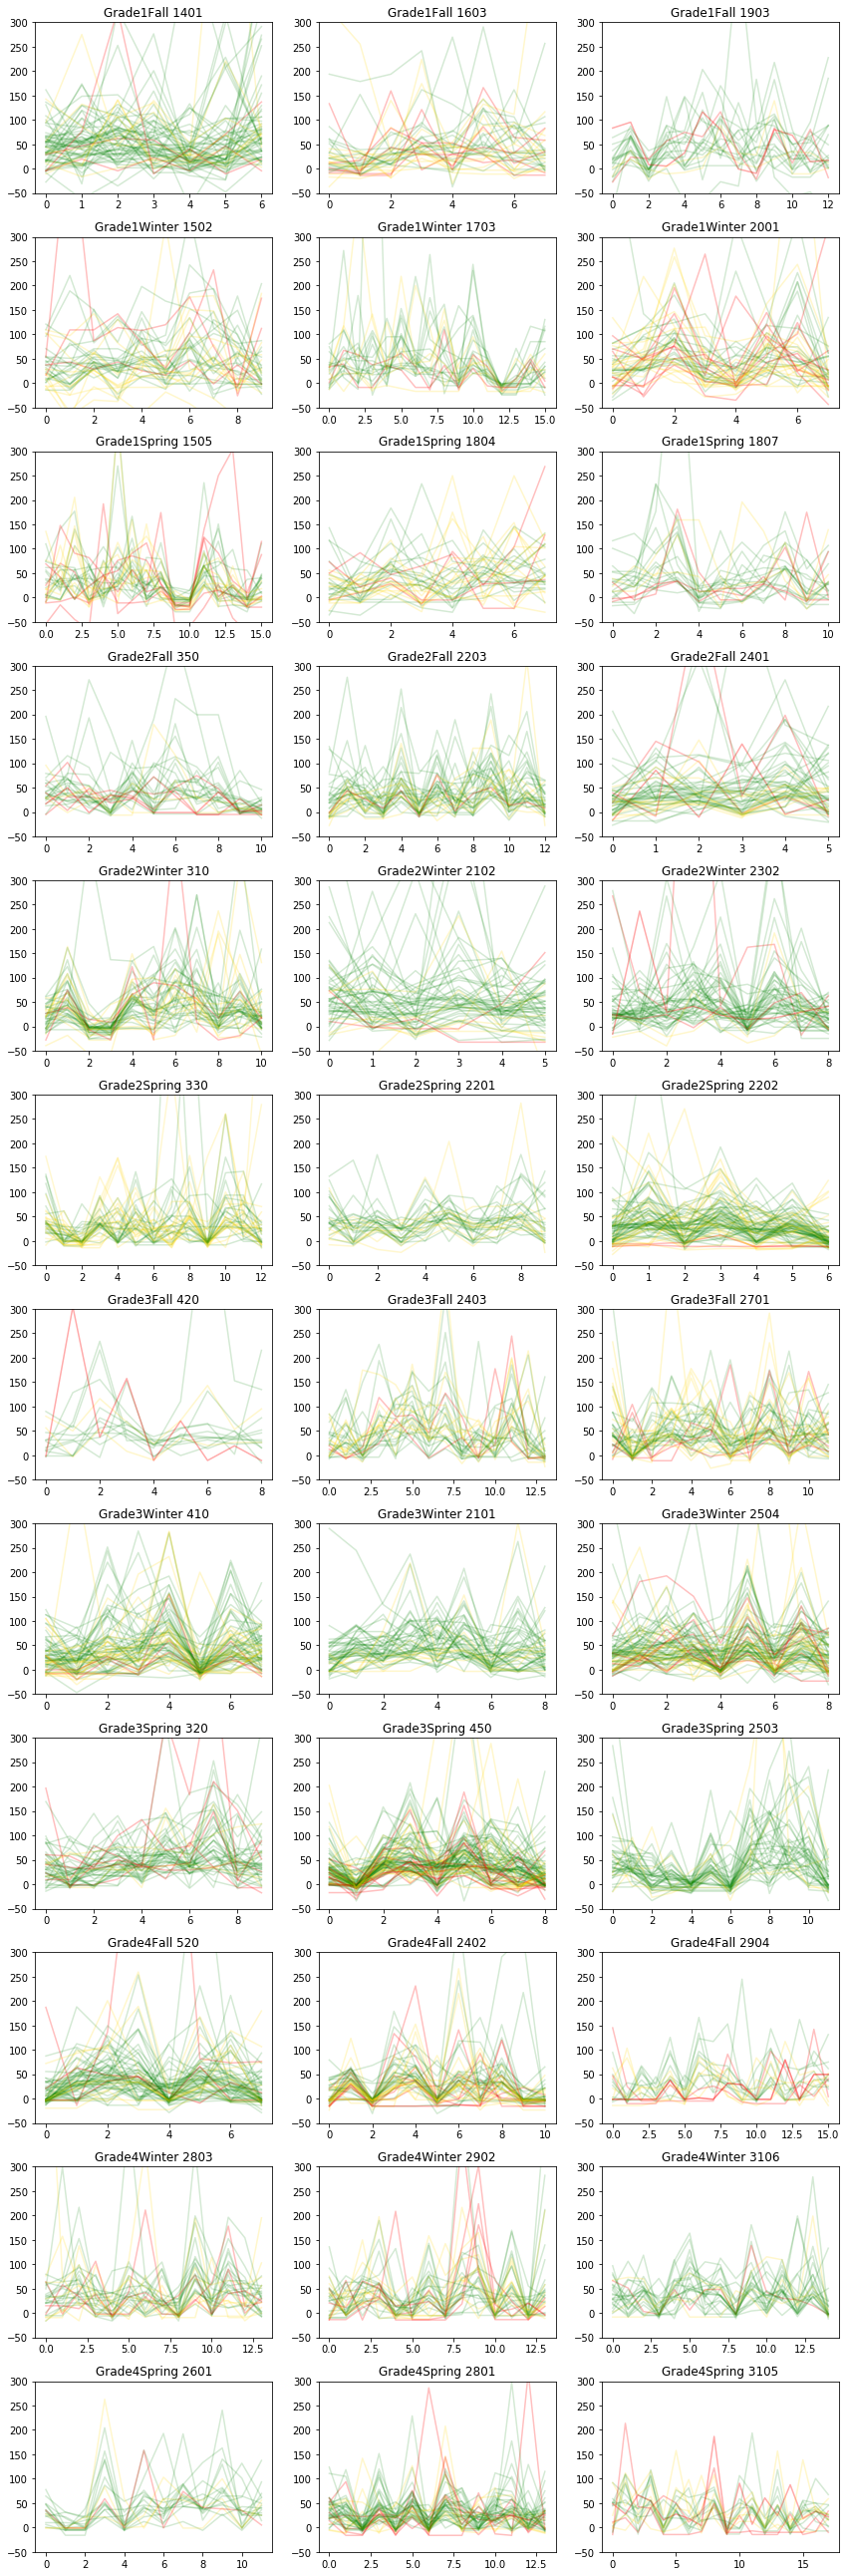

In [10]:
form_to_items = defaultdict(list)
for item, form in item_to_form.items():
    form_to_items[form].append(int(item))

fig, axs = plt.subplots(12, 3)
fig.set_figheight(36)
fig.set_figwidth(12)

for idx1_for_plotting, grade in enumerate(['Grade1', 'Grade2', 'Grade3', 'Grade4']):
    for idx2_for_plotting, term in enumerate(['Fall', 'Winter', 'Spring']):
        form = grade + term
        df_this_form = df.loc[df.Form == form]
        
        for idx, (session, response, item, _, _, avg_annote_12, avg_annote_14) in df_this_form.iterrows():
            data = [x[1] for x in session_to_data[str(session)] if x[0] == int(item)]
            if len(data) != 1: # 5 readings missings from G4W
                continue
            
            data = data[0]
            
            data_correct_word_read = data['correct_word_read']
            
            if not all(data_correct_word_read):
                continue
            
            if avg_annote_14 == 3:
                line_color = 'green'
            elif avg_annote_14 <= 2:
                line_color = 'red'
            else:
                line_color = 'gold'
                
            x_plot_idx = 3 * idx1_for_plotting + idx2_for_plotting
            y_plot_idx = form_to_items[form].index(int(item))
            
            axs[x_plot_idx][y_plot_idx].plot(
                np.arange(len(data['pause_len'])),
                np.array(data['pause_len']) - data['mean_span_pause_len'],
                color=line_color,
                alpha=(1 / 2 / avg_annote_14)
            )
            axs[x_plot_idx, y_plot_idx].set_ylim(-50, 300)
            axs[x_plot_idx, y_plot_idx].set_title(form + ' ' + str(item))

plt.tight_layout()
plt.savefig('distribution-of-pauses-normalized-more-red.png')

In [11]:
tmp_mask = [0, 1, 1, 0, 1]
vals = [10,20,30,40,50]
def filter_by_mask(lst, msk):
    rv = []
    for i, x in enumerate(msk):
        if x:
            rv.append(lst[i])
    return rv

In [12]:
def get_color(annote, red_cutoff=2):
    if annote == 3:
        return 'green'
    if annote <= red_cutoff:
        return 'red'
    return 'gold'

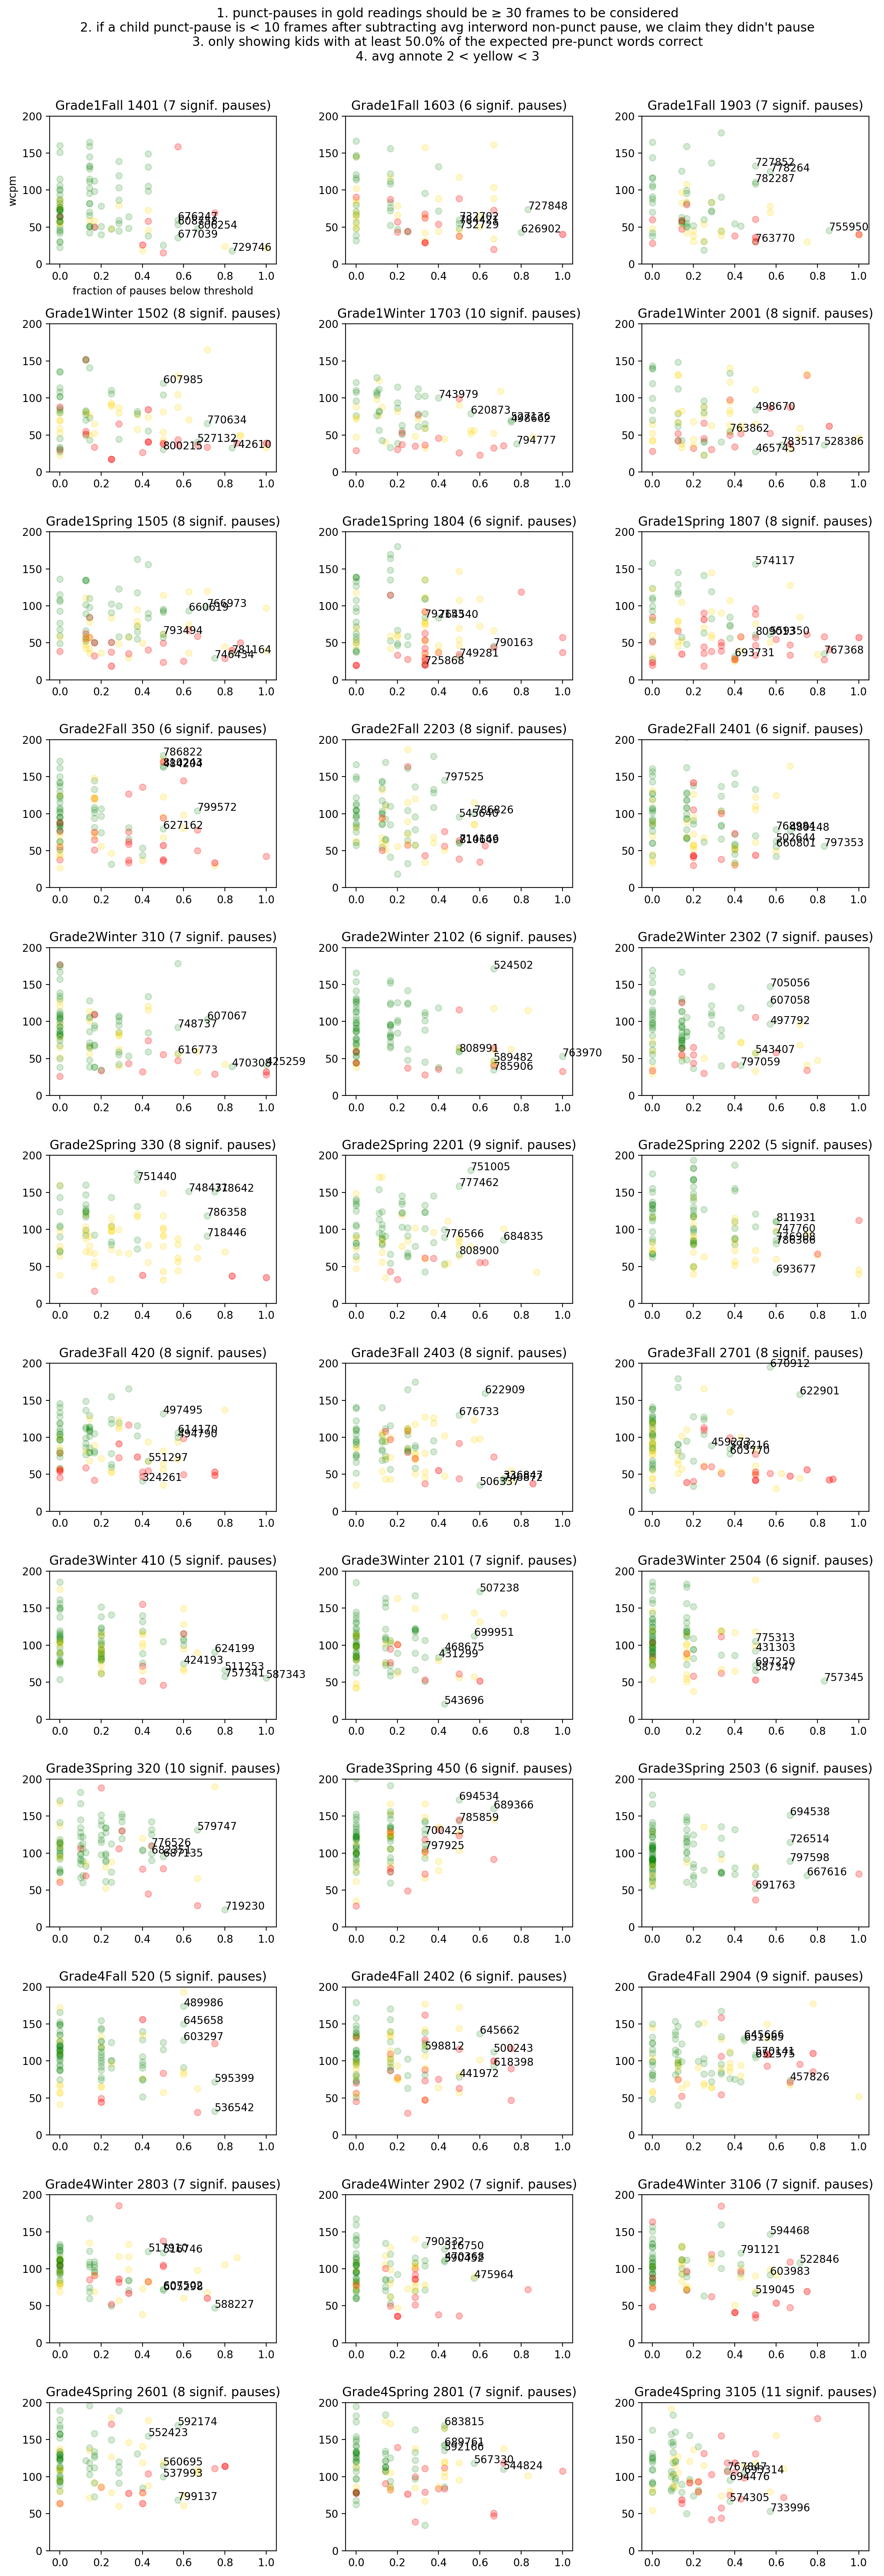

In [32]:
show_line_plot = False

fig, axs = plt.subplots(12, 3)
fig.set_dpi(200)
fig.set_figheight(36)
fig.set_figwidth(12)


# avg pauses in gold/good readings should be at least this amount to be considered a significant pause
PAUSE_SIGNIFICANCE_THRESHOLD = 30

# after subtracting mean pause length, if lower than this, then we claim that the kid "didn't pause"
CHILD_NORMALIZED_PAUSE_SIGNIFICANCE_THRESHOLD = 10

# kid should get at least this proportion of expected punctuation words correct.
CORRECTNESS_THRESHOLD = 1/2

# ? Subtract (normalize) mean pause length ?
SUBTRACT_MEAN_PAUSE_LENGTH = True

title = '''1. punct-pauses in gold readings should be ≥ {} frames to be considered
2. if a child punct-pause is < {} frames after subtracting avg interword non-punct pause, we claim they didn't pause
3. only showing kids with at least {:.1f}% of the expected pre-punct words correct
4. avg annote 2 < yellow < 3
'''.format(PAUSE_SIGNIFICANCE_THRESHOLD,
           CHILD_NORMALIZED_PAUSE_SIGNIFICANCE_THRESHOLD,
           100 * CORRECTNESS_THRESHOLD)

fig.suptitle(title)

if show_line_plot:
    axs[0,0].set_ylabel('frames')
    axs[0,0].set_xlabel('pauses at punct.')
else:
    axs[0,0].set_ylabel('wcpm')
    axs[0,0].set_xlabel('fraction of pauses below threshold')

form_item_to_green_responses = defaultdict(list)
form_item_to_yellow_responses = defaultdict(list)
    
for idx1_for_plotting, grade in enumerate(['Grade1', 'Grade2', 'Grade3', 'Grade4']):
    
#     if grade in {'Grade1', 'Grade2', 'Grade4'}:
#         continue
    
    
    for idx2_for_plotting, term in enumerate(['Fall', 'Winter', 'Spring']):
        form = grade + term
        df_this_form = df.loc[df.Form == form]
        
        for idx, (session, response, item, _, _, avg_annote_12, avg_annote_14) in df_this_form.iterrows():
            data = [x[1] for x in session_to_data[str(session)] if x[0] == int(item)]
            if len(data) != 1: # 5 readings missings from G4W
                continue
            
            data = data[0]
            
            gold_pauses_table = gold_readings_data.loc[gold_readings_data['item'] == int(item)]
            med_gold_pauses_list = gold_pauses_table['pause_med']
            
            gold_pauses_list_significant_mask = [
                1 if pause_len > PAUSE_SIGNIFICANCE_THRESHOLD else 0
                for pause_len in med_gold_pauses_list
            ]
            
            num_expected_pauses = sum(gold_pauses_list_significant_mask)
            
            child_correct_word_read_flags = data['correct_word_read']
            
            expected_pauses_that_child_got_correct_flags =\
                np.array(gold_pauses_list_significant_mask) & np.array(child_correct_word_read_flags)
            
            num_expected_pauses_that_child_got_correct = sum(expected_pauses_that_child_got_correct_flags)
            
            if num_expected_pauses_that_child_got_correct / num_expected_pauses >= CORRECTNESS_THRESHOLD:
                child_pauses_lengths = data['pause_len']
                
                x_ordinal_punct_list = []
                y_frame_count_list = []
                
                filtered_expected_pauses_that_child_got_correct_flags = filter_by_mask(
                    list(expected_pauses_that_child_got_correct_flags),
                    gold_pauses_list_significant_mask
                )
                
                filtered_child_pauses_lengths = filter_by_mask(
                    child_pauses_lengths,
                    gold_pauses_list_significant_mask
                )
                
                assert len(filtered_expected_pauses_that_child_got_correct_flags) ==\
                    len(filtered_child_pauses_lengths)
                
                for i, child_got_word_correct in enumerate(filtered_expected_pauses_that_child_got_correct_flags):
                    if child_got_word_correct:
                        x_ordinal_punct_list.append(i)
                        y_frame_count_list.append(filtered_child_pauses_lengths[i])
                
                if SUBTRACT_MEAN_PAUSE_LENGTH:
                    y_frame_count_list = np.array(y_frame_count_list) - data['mean_span_pause_len']
                
                x_plot_idx = 3 * idx1_for_plotting + idx2_for_plotting
                y_plot_idx = form_to_items[form].index(int(item))
                
                color = get_color(avg_annote_14)
                
                if show_line_plot:
                
                    # COLOR + PLOT

                    axs[x_plot_idx, y_plot_idx].plot(
                        x_ordinal_punct_list,
                        y_frame_count_list,
                        color=color,
                        alpha=(1 / 2 / avg_annote_14)
                    )
                    axs[x_plot_idx, y_plot_idx].set_ylim(-100, 100)
                    axs[x_plot_idx, y_plot_idx].set_title(form + ' ' + str(item))
                else:
                    # show scatter
                    
                    fraction_below_threshold =\
                        sum(np.array(y_frame_count_list) < CHILD_NORMALIZED_PAUSE_SIGNIFICANCE_THRESHOLD)/\
                        len(y_frame_count_list)
                    
                    
                    
                    wcpm = float(child_response_to_wcpm[response])
                    axs[x_plot_idx, y_plot_idx].scatter(
                        fraction_below_threshold,
                        wcpm,
                        color=color,
                        alpha=(1 / 2 / avg_annote_14)
                    )
                    
                    if color == 'green':
                        form_item_to_green_responses[form + ' ' + str(item)]\
                            .append((fraction_below_threshold, wcpm, response))
                    if color == 'gold':
                        form_item_to_yellow_responses[form + ' ' + str(item)]\
                            .append((fraction_below_threshold, wcpm, response))
                    
#                     axs[x_plot_idx, y_plot_idx].annotate(str(response), (fraction_below_threshold, wcpm))
                    axs[x_plot_idx, y_plot_idx].set_xlim(-.05, 1.05)
                    axs[x_plot_idx, y_plot_idx].set_ylim(0, 200)
                    axs[x_plot_idx, y_plot_idx].set_title(form + ' ' + str(item) +\
                                                          ' ({} signif. pauses)'.format(len(filtered_child_pauses_lengths)))
            
#                 break
            
#             break
         
#         break
#     break

def term_to_num(term):
    if term == 'Fall':
        return 0
    if term == 'Winter':
        return 1
    if term == 'Spring':
        return 2


if not show_line_plot:
    for form_item, green_responses in form_item_to_green_responses.items():
        descending_list_by_proportion_of_short_pauses = list(reversed(sorted(green_responses, key=lambda x: x[0])))
        form, item = form_item.split()
        grade = int(form[5])
        term = form[6:]

        axx = 3 * (grade - 1) + term_to_num(term)
        axy = form_to_items[form].index(int(item))

        for selected_point in descending_list_by_proportion_of_short_pauses[:5]:
            x_val, y_val, response = selected_point
            axs[axx, axy].annotate(str(response), (x_val, y_val))
    
    
#     print(descending_list_by_proportion_of_short_pauses[:5])

# plt.subplots_adjust(top=3)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('distribution-of-pauses-only-significant-expected-pauses-scatter-rightmost-greens.png')

In [29]:
session_to_data['38532']

[(2403,
  {'pause_len': [21, 117, 0, 84, 60, 90, 72, 126, 54, 45, 0, 54, 30, 0],
   'correct_word_read': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   'is_pause': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   'median_span_pause_len': 0.0,
   'mean_span_pause_len': 0.5172413793103449}),
 (2701,
  {'pause_len': [21, 39, 108, 108, 105, 93, 27, 93, 105, 9, 111, 129],
   'correct_word_read': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   'is_pause': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
   'median_span_pause_len': 0.0,
   'mean_span_pause_len': 0.6875}),
 (420,
  {'pause_len': [30, 0, 78, 54, 21, 24, 33, 24, 27],
   'correct_word_read': [1, 1, 1, 1, 1, 1, 1, 1, 1],
   'is_pause': [1, 1, 1, 1, 1, 1, 1, 1, 1],
   'median_span_pause_len': 0.0,
   'mean_span_pause_len': 1.2307692307692308})]

In [ ]:
fig, axs = plt.subplots(4, 3)
fig.set_figheight(12)
fig.set_figwidth(12)

for idx1_for_plotting, grade in enumerate(['Grade1', 'Grade2', 'Grade3', 'Grade4']):
    for idx2_for_plotting, term in enumerate(['Fall', 'Winter', 'Spring']):
        form = grade + term
        df_this_form = df.loc[df.Form == form]
        
        green_x = []
        green_y = []
        
        yellow_x = []
        yellow_y = []
        
        red_x = []
        red_y = []
        
        for idx, (session, response, item, _, _, avg_annote_12, avg_annote_14) in df_this_form.iterrows():
            data = [x[1] for x in session_to_data[str(session)] if x[0] == int(item)]
            if len(data) != 1: # 5 readings missings from G4W
                continue
            
            data = data[0]
            
            relevant_gold_pauses = gold_readings_data.loc[gold_readings_data['item'] == int(item)]
            gold_pause_mean = relevant_gold_pauses.pause_mean
            gold_pause_1q  = relevant_gold_pauses.pause_1q
            gold_pause_3q  = relevant_gold_pauses.pause_3q
            gold_pause_sstd = relevant_gold_pauses.pause_sstd
            
            relevant_good_child_readings = good_child_readings_data.loc[good_child_readings_data['item'] == int(item)]
            good_child_pause_mean = relevant_good_child_readings.pause_mean
            good_child_pause_1q = relevant_good_child_readings.pause_1q
            good_child_pause_3q = relevant_good_child_readings.pause_3q
            good_child_pause_sstd = relevant_good_child_readings.pause_sstd
            
            data_pause_len = data['pause_len']
            data_mean_span_pause_len = data['mean_span_pause_len']
            data_median_span_pause_len = data['median_span_pause_len']
            data_correct_word_read = data['correct_word_read']
            
            x_val = compute_proportion_below_1q(
                data_pause_len,
                data_median_span_pause_len,
                good_child_pause_mean,
                good_child_pause_1q,
                good_child_pause_sstd,
                is_correct_array=data_correct_word_read
            )
#             x_val = avg_abs_diff(data['pause_len'], gold_pause_mean)

    
            
#             y_val = data['mean_span_pause_len']
#             y_val = float(child_response_to_wcpm[response])
#             y_val = avg_abs_diff(data['pause_len'], good_child_pause_mean)
            
            y_val = compute_avg_dev_below_1q(
                data_pause_len,
                data_median_span_pause_len,
                good_child_pause_mean,
                good_child_pause_1q,
                good_child_pause_sstd,
                is_correct_array=data_correct_word_read
            )
    
            if avg_annote_14 == 3:
                green_x.append(x_val)
                green_y.append(y_val)
            elif avg_annote_14 <= 1.5:
                red_x.append(x_val)
                red_y.append(y_val)
            else:
                yellow_x.append(x_val)
                yellow_y.append(y_val)
        
        axs[idx1_for_plotting][idx2_for_plotting].set_xlim(-.1, 1)
        axs[idx1_for_plotting][idx2_for_plotting].set_ylim(-4, 4)

        axs[idx1_for_plotting][idx2_for_plotting].scatter(green_x, green_y, color='green', marker='+', alpha=.2)
        axs[idx1_for_plotting][idx2_for_plotting].scatter(red_x, red_y, color='red', marker='x', alpha=.3)
        axs[idx1_for_plotting][idx2_for_plotting].scatter(yellow_x, yellow_y, color='gold', marker='v', alpha=.2)
#         axs[idx1_for_plotting][idx2_for_plotting].yaxis.set_visible(False)
        axs[idx1_for_plotting][idx2_for_plotting].set_title(form)
        
#         break
#     break
plt.tight_layout()